In [1]:
import cv2 
import torch 
import pandas as pd
import random
import warnings 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from models.space_net import SPACE
from models.race import RACE, ACE
from models.hdrnet import PICE_B
from utils import decompose_imgs, compose_imgs
from ssim_map import pos_similarity_ratio
from saliency_losses import nss, corr_coeff, kld_loss, log_softmax, softmax
from utils import contrast_loss_G, contrast_loss_L, R_imgs, R_sclr, EME
from ISFDataset import ISFDataset
from torch.utils.data import DataLoader
from kornia.losses.ssim import ssim_loss
import numpy as np

ERROR:albumentations.check_version:Error fetching version info
Traceback (most recent call last):
  File "c:\Users\lps3090\Anaconda3\envs\oled\lib\urllib\request.py", line 1348, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "c:\Users\lps3090\Anaconda3\envs\oled\lib\http\client.py", line 1283, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "c:\Users\lps3090\Anaconda3\envs\oled\lib\http\client.py", line 1329, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "c:\Users\lps3090\Anaconda3\envs\oled\lib\http\client.py", line 1278, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "c:\Users\lps3090\Anaconda3\envs\oled\lib\http\client.py", line 1038, in _send_output
    self.send(msg)
  File "c:\Users\lps3090\Anaconda3\envs\oled\lib\http\client.py", line 976, in send
    self.connect()
  File "c:\Users\lps3090\Anaconda3\envs\oled\lib\http\client.py", l

In [4]:
img = cv2.imread("./test_images/img142.bmp") 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
orig_img = img.copy()
img = torch.from_numpy(img).permute(2,0,1).unsqueeze(0) / 255. 
y, cbcr = decompose_imgs(img)

gamma = 2.2
k = 0.6
R = 1 - k ** gamma
y_R = y * k

True


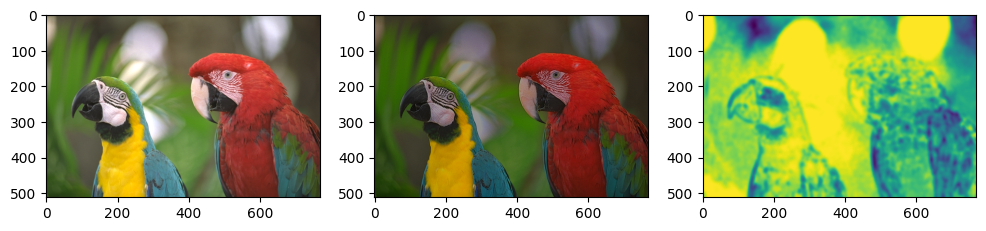

tensor(0.9322)


In [5]:
model = SPACE(apply_center_bias=True, apply_gfcorrection=True, apply_len=True)
model.load_state_dict(torch.load("C:/Users/lps3090/Desktop/space/results/PAVE.pth"))    
print(torch.cuda.is_available())

with torch.no_grad():
    y_hat = model(y, R=R)
rgb_hat = torch.clamp(compose_imgs(y_hat, cbcr), 0., 1.)
cd = pos_similarity_ratio(y_hat, y_R, y)
img_out = rgb_hat.squeeze().permute(1,2,0).cpu().numpy()
cd_out = -cd.squeeze().cpu().numpy()

_ssim_loss = 2 * ssim_loss(y_hat, y, window_size=5, reduction='mean') 
f, axarr = plt.subplots(1,3, figsize=(12,12))

axarr[0].imshow(orig_img)
axarr[1].imshow(img_out)
axarr[2].imshow(cd_out)
plt.show()
print(1 - _ssim_loss/2)